The following notebook was designed and tested in Google Colab with T4 GPU.

All results and models are described in the report.

# Dependencies

In [1]:
!git clone https://huggingface.co/hplisiecki/word2affect_english
!git clone https://huggingface.co/hplisiecki/word2affect_polish

Cloning into 'word2affect_english'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 17), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (41/41), 324.63 KiB | 1.75 MiB/s, done.
Filtering content: 100% (2/2), 846.68 MiB | 26.35 MiB/s, done.
Cloning into 'word2affect_polish'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 19), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (44/44), 813.35 KiB | 2.77 MiB/s, done.
Filtering content: 100% (2/2), 967.58 MiB | 41.42 MiB/s, done.


In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import json
import numpy as np
import torch
import copy
from time import time
import matplotlib.pyplot as plt
from word2affect_english.model_script import CustomModel as CustomModel_en
from word2affect_polish.model_script import CustomModel as CustomModel_pl

In [3]:
np.random.seed(123)
torch.manual_seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

# Data

In [4]:
with open('anon_conversations.json', 'r', encoding='utf-8') as f:
  data = json.load(f)

# Models

## Descrete

In [5]:
def classify_long_text(model, tokenizer, text):
      """
      Classifies a list of texts, handling cases where text length exceeds the model's max token limit.

      Args:
          model (AutoModelForSequenceClassification): Model to use.
          tokenizer (AutoTokenizer): Tokenizer to use.
          texts (str): Text to classify.
      Returns:
          tuple: Classification label and probabilities.
      """
      max_length = tokenizer.model_max_length

      # Tokenize without truncation
      tokens = tokenizer(text, return_tensors="pt", truncation=False)
      input_ids = tokens["input_ids"]
      attention_mask = tokens["attention_mask"]

      # Split input into manageable chunks
      input_ids_split = torch.split(input_ids, max_length, dim=1)
      attention_mask_split = torch.split(attention_mask, max_length, dim=1)

      # Classify each chunk and aggregate results
      logits_list = []
      with torch.no_grad():
          for ids, mask in zip(input_ids_split, attention_mask_split):
              #print("Input IDs shape:", ids.shape)
              #print("Attention Mask shape:", mask.shape)
              outputs = model(input_ids=ids.to(0), attention_mask=mask.to(0))
              logits_list.append(outputs.logits)

      # Aggregate logits for final classification
      logits = torch.cat(logits_list, dim=0).mean(dim=0)  # Average logits across chunks
      probs = torch.softmax(logits, dim=-1).cpu().numpy()
      label = torch.argmax(logits, dim=-1).item()

      return label, probs

In [6]:
def classify_entire(data, model, tokenizer, is_english=False, verbose=False):
  results = []
  n = len(data['conversations'])
  i = 0
  start_time = time()
  for conv in data['conversations']:
    result = {}
    i += 1
    if verbose and i % 100 == 0:
      end_time = time()
      print(f"{i}/{n}, {round(end_time-start_time, 2)}s")
      start_time = time()
    for part in data['participants']:
      if is_english:
        label, probs = classify_long_text(model, tokenizer, conv[f"{part}_translated"])
        result[part+"_label"] = label
        result[part+"_probs"] = list(probs)
      else:
        label, probs = classify_long_text(model, tokenizer, conv[part])
        result[part+"_label"] = label
        result[part+"_probs"] = list(probs)
    results.append(result)
  return results

### Polish RoBERTa

In [7]:
tokenizer_roberta_pl = AutoTokenizer.from_pretrained("visegradmedia-emotion/Emotion_RoBERTa_polish6")
model_roberta_pl = AutoModelForSequenceClassification.from_pretrained("visegradmedia-emotion/Emotion_RoBERTa_polish6").to(0)
dict_roberta_pl = {0: "anger", 1: "fear", 2: "disgust", 3: "sadness", 4: "joy", 5: "none_of_them"}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [8]:
results_roberta_pl = classify_entire(data, model_roberta_pl, tokenizer_roberta_pl, is_english=False, verbose=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors


100/1580, 5.93s
200/1580, 3.29s
300/1580, 4.12s
400/1580, 7.02s
500/1580, 7.87s
600/1580, 6.65s
700/1580, 4.67s
800/1580, 5.66s
900/1580, 4.26s
1000/1580, 3.7s
1100/1580, 4.84s
1200/1580, 3.5s
1300/1580, 3.35s
1400/1580, 4.13s
1500/1580, 4.03s


### English BERT

In [9]:
tokenizer_bert_en = AutoTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
model_bert_en = AutoModelForSequenceClassification.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion').to(0)
dict_bert_en = model_bert_en.config.id2label

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
results_bert_en = classify_entire(data, model_bert_en, tokenizer_bert_en, is_english=True, verbose=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


100/1580, 1.17s
200/1580, 1.48s
300/1580, 1.48s
400/1580, 2.09s
500/1580, 1.99s
600/1580, 1.88s
700/1580, 1.65s
800/1580, 1.72s
900/1580, 1.62s
1000/1580, 1.71s
1100/1580, 1.67s
1200/1580, 1.53s
1300/1580, 1.49s
1400/1580, 1.27s
1500/1580, 1.21s


### English RoBERTa

In [11]:
tokenizer_roberta_en = AutoTokenizer.from_pretrained('SamLowe/roberta-base-go_emotions')
model_roberta_en = AutoModelForSequenceClassification.from_pretrained('SamLowe/roberta-base-go_emotions').to(0)
dict_roberta_en = model_roberta_en.config.id2label

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [12]:
results_roberta_en = classify_entire(data, model_roberta_en, tokenizer_roberta_en, is_english=True, verbose=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


100/1580, 2.49s
200/1580, 2.56s
300/1580, 2.87s
400/1580, 5.61s
500/1580, 6.51s
600/1580, 5.72s
700/1580, 5.55s
800/1580, 3.58s
900/1580, 3.3s
1000/1580, 3.13s
1100/1580, 3.87s
1200/1580, 3.6s
1300/1580, 4.03s
1400/1580, 6.09s
1500/1580, 3.81s


## Dimensional

In [58]:
def conversation_affect(model, tokenizer, conversation):
  words = conversation.split(" ")
  all_outputs = []

  for word in words:
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
      outputs = model(inputs['input_ids'].to(0), inputs['attention_mask'].to(0))
      values = [output.item() for output in outputs]
      all_outputs.append(values)

  return torch.tensor(all_outputs).mean(dim=0).tolist()

def entire_affect(data, model, tokenizer, is_english=False, verbose=False):
  results = []
  n = len(data['conversations'])
  i = 0
  start_time = time()
  for conv in data['conversations']:
    result = {}
    i += 1
    if verbose and i % 100 == 0:
      end_time = time()
      print(f"{i}/{n}, {round(end_time-start_time, 2)}s")
      start_time = time()
    for part in data['participants']:
      if is_english:
        result[part] = conversation_affect(model, tokenizer, conv[f"{part}_translated"])
      else:
        result[part] = conversation_affect(model, tokenizer, conv[part])
    results.append(result)
  return results

### English word2affect

In [59]:
model_affect_en = CustomModel_en.from_pretrained("word2affect_english").to(0)
tokenizer_affect_en = AutoTokenizer.from_pretrained("word2affect_english")

/content/word2affect_english/model_script.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{model_dir}/pytorch_model.bin', map_location=torch.d

In [60]:
results_affect_en = entire_affect(data, model_affect_en, tokenizer_affect_en, is_english=True, verbose=True)

100/1580, 128.64s
200/1580, 205.04s
300/1580, 180.82s
400/1580, 389.75s
500/1580, 401.77s
600/1580, 384.2s
700/1580, 330.14s
800/1580, 336.28s
900/1580, 315.69s
1000/1580, 291.15s
1100/1580, 267.41s
1200/1580, 295.19s
1300/1580, 284.34s
1400/1580, 204.3s
1500/1580, 188.72s


### Polish word2affect

In [69]:
model_affect_pl = CustomModel_pl.from_pretrained("word2affect_polish").to(0)
tokenizer_affect_pl = AutoTokenizer.from_pretrained("word2affect_polish")

/content/word2affect_polish/model_script.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{model_dir}/pytorch_model.bin', map_location=torch.de

In [70]:
results_affect_pl = entire_affect(data, model_affect_pl, tokenizer_affect_pl, is_english=True, verbose=True)

100/1580, 113.72s
200/1580, 184.55s
300/1580, 162.89s
400/1580, 349.61s
500/1580, 364.68s
600/1580, 355.18s
700/1580, 304.37s
800/1580, 306.61s
900/1580, 283.07s
1000/1580, 263.95s
1100/1580, 251.3s
1200/1580, 273.09s
1300/1580, 262.8s
1400/1580, 187.77s
1500/1580, 172.65s


# Preliminary results

In [18]:
def only_labels(results, participants):
  labels = {}
  i = 1
  for part in participants:
    labels[f"part{i}"] = [result[part+"_label"] for result in results]
    i+=1
  return labels

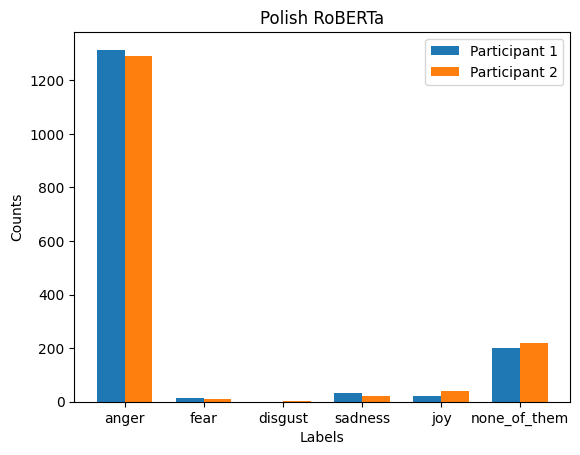

In [65]:
# polish roberta

labels = only_labels(results_roberta_pl, data['participants'])
counts_par1 = {label: 0 for label in dict_roberta_pl.values()}
counts_par2 = {label: 0 for label in dict_roberta_pl.values()}

for i in range(len(labels["part1"])):
  counts_par1[dict_roberta_pl[labels["part1"][i]]] += 1
  counts_par2[dict_roberta_pl[labels["part2"][i]]] += 1

keys = list(counts_par1.keys())
values1 = list(counts_par1.values())
values2 = list(counts_par2.values())

bar_width = 0.35

x_pos = np.arange(len(keys))

plt.bar(x_pos, values1, width=bar_width, label='Participant 1')
plt.bar(x_pos + bar_width, values2, width=bar_width, label='Participant 2')

plt.xticks(x_pos + bar_width / 2, keys)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Polish RoBERTa')
plt.legend()

plt.savefig('polish_roberta.png')
plt.show()

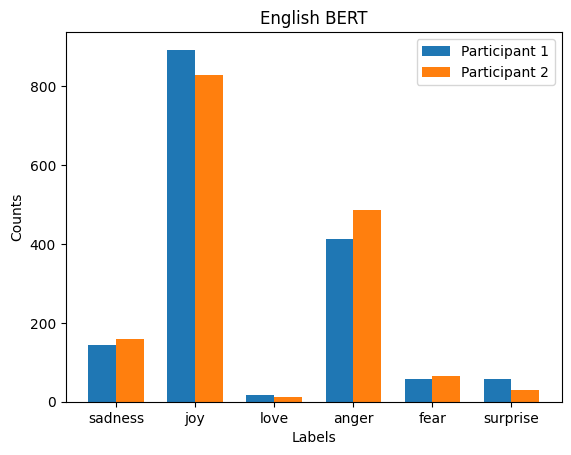

In [66]:
# english bert

labels = only_labels(results_bert_en, data['participants'])
counts_par1 = {label: 0 for label in dict_bert_en.values()}
counts_par2 = {label: 0 for label in dict_bert_en.values()}

for i in range(len(labels["part1"])):
  counts_par1[dict_bert_en[labels["part1"][i]]] += 1
  counts_par2[dict_bert_en[labels["part2"][i]]] += 1

keys = list(counts_par1.keys())
values1 = list(counts_par1.values())
values2 = list(counts_par2.values())

bar_width = 0.35

x_pos = np.arange(len(keys))

plt.bar(x_pos, values1, width=bar_width, label='Participant 1')
plt.bar(x_pos + bar_width, values2, width=bar_width, label='Participant 2')

plt.xticks(x_pos + bar_width / 2, keys)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('English BERT')
plt.legend()

plt.savefig('english_bert.png')
plt.show()

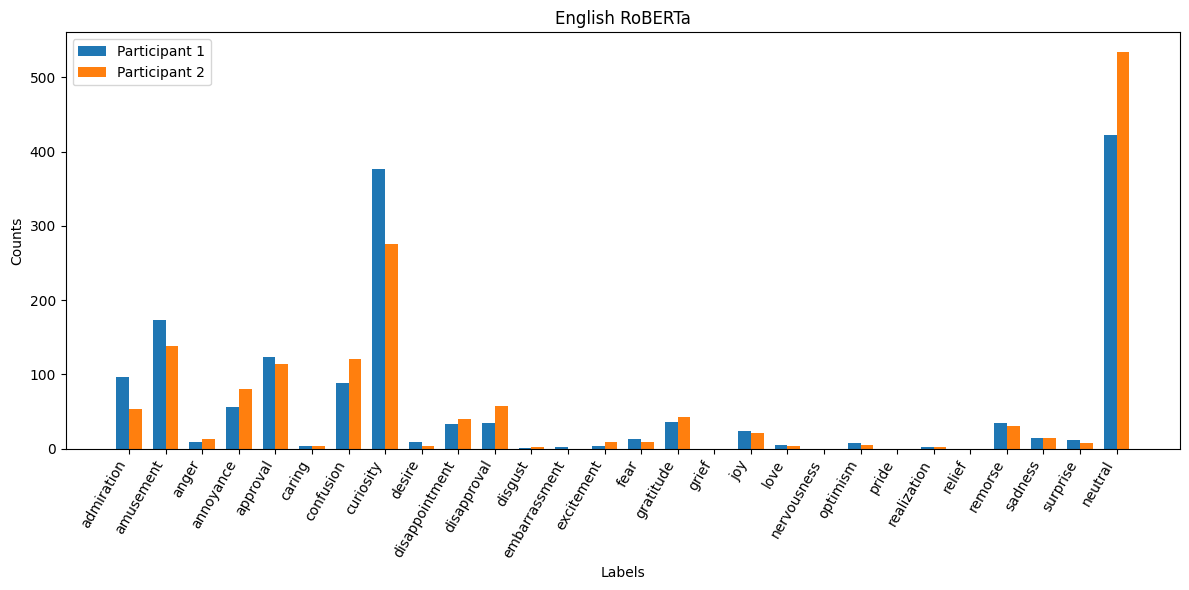

In [67]:
# english roberta

labels = only_labels(results_roberta_en, data['participants'])
counts_par1 = {label: 0 for label in dict_roberta_en.values()}
counts_par2 = {label: 0 for label in dict_roberta_en.values()}

for i in range(len(labels["part1"])):
  counts_par1[dict_roberta_en[labels["part1"][i]]] += 1
  counts_par2[dict_roberta_en[labels["part2"][i]]] += 1

keys = list(counts_par1.keys())
values1 = list(counts_par1.values())
values2 = list(counts_par2.values())

bar_width = 0.35
plt.figure(figsize=(12, 6))

x_pos = np.arange(len(keys))

plt.bar(x_pos, values1, width=bar_width, label='Participant 1')
plt.bar(x_pos + bar_width, values2, width=bar_width, label='Participant 2')

plt.xticks(x_pos + bar_width / 2, keys, rotation=60, ha='right')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('English RoBERTa')
plt.legend()

plt.tight_layout()

plt.savefig('english_roberta.png')
plt.show()

In [48]:
dimensions_pl = ['Valence', 'Arousal', 'Dominance', 'Origin', 'Significance', 'Concreteness', 'Imageability', 'Age of Acquisition']
dimensions_en = ['Valence', 'Arousal', 'Dominance', 'Age of Acquisition', 'Concreteness']

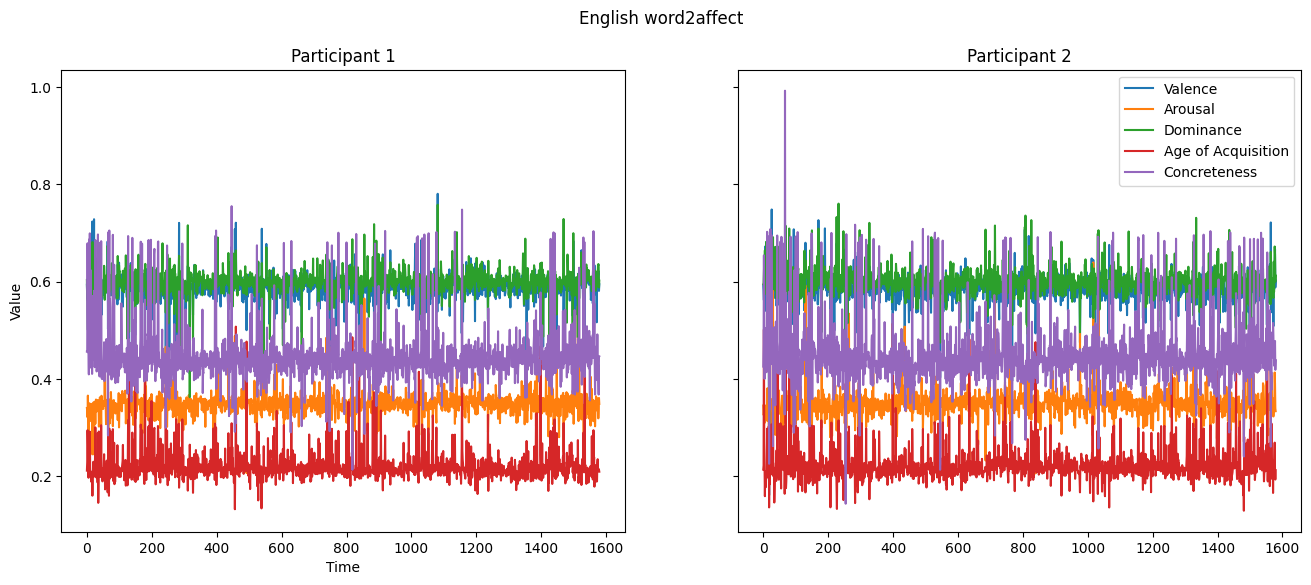

In [74]:
part1, part2 = data["participants"]
results_affect_en1 = [d[part1] for d in results_affect_en]
results_affect_en2 = [d[part2] for d in results_affect_en]

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i in range(len(dimensions_en)):
    ax[0].plot(range(len(results_affect_en)), [data[i] for data in results_affect_en1], label=dimensions_en[i])
    ax[1].plot(range(len(results_affect_en)), [data[i] for data in results_affect_en2], label=dimensions_en[i])

ax[0].set_title("Participant 1")
ax[1].set_title("Participant 2")
plt.suptitle("English word2affect")
ax[0].set_ylabel(f'Value')
ax[0].set_xlabel(f'Time')
plt.legend()
plt.savefig('english_word2affect.png')
plt.show()

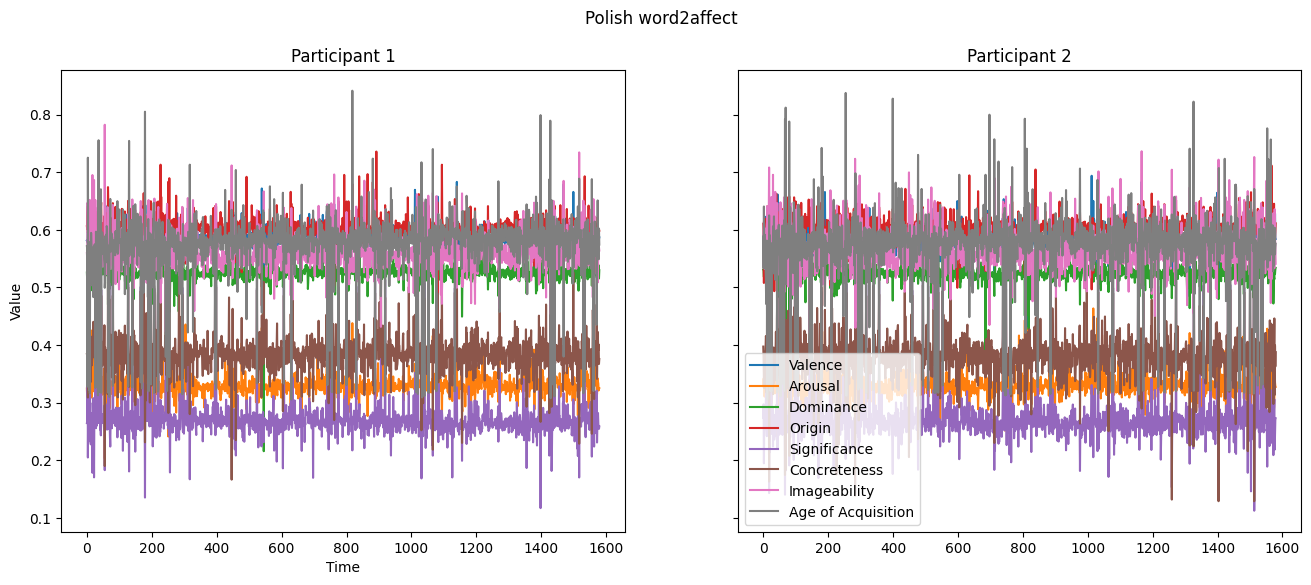

In [73]:
part1, part2 = data["participants"]
results_affect_pl1 = [d[part1] for d in results_affect_pl]
results_affect_pl2 = [d[part2] for d in results_affect_pl]

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i in range(len(dimensions_pl)):
    ax[0].plot(range(len(results_affect_pl)), [data[i] for data in results_affect_pl1], label=dimensions_pl[i])
    ax[1].plot(range(len(results_affect_pl)), [data[i] for data in results_affect_pl2], label=dimensions_pl[i])

ax[0].set_title("Participant 1")
ax[1].set_title("Participant 2")
plt.suptitle("Polish word2affect")
ax[0].set_ylabel(f'Value')
ax[0].set_xlabel(f'Time')
plt.legend()
plt.savefig('polish_word2affect.png')
plt.show()